# **Importing required libraries**

In [ ]:
import os
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import keras
from keras.layers import Input, Dense
from keras import regularizers
import tensorflow as tf
from keras.models import Model

In [ ]:
# mounting google drive to access dataset stored on it
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Loading dataset**

- Malicious URLs dataset of 6,51,191 URLs
- 4,28,103 are benign or safe
- 96,457 are defacement 
- 94,111 are phishing 
- 32,520 are malware 

In [ ]:
# import
df=pd.read_csv("/content/drive/MyDrive/datasets/ml_data/malicious_phish.csv")
print(df.shape)
df.head()

(651191, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
df.type.value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

# Exploratory Data Analysis (EDA)
- Wordcloud
- Feature Engineering
- Feature Distribution

## Plotting Wordcloud

In [ ]:
df_phish = df[df.type=='phishing']
df_malware = df[df.type=='malware']
df_deface = df[df.type=='defacement']
df_benign = df[df.type=='benign']


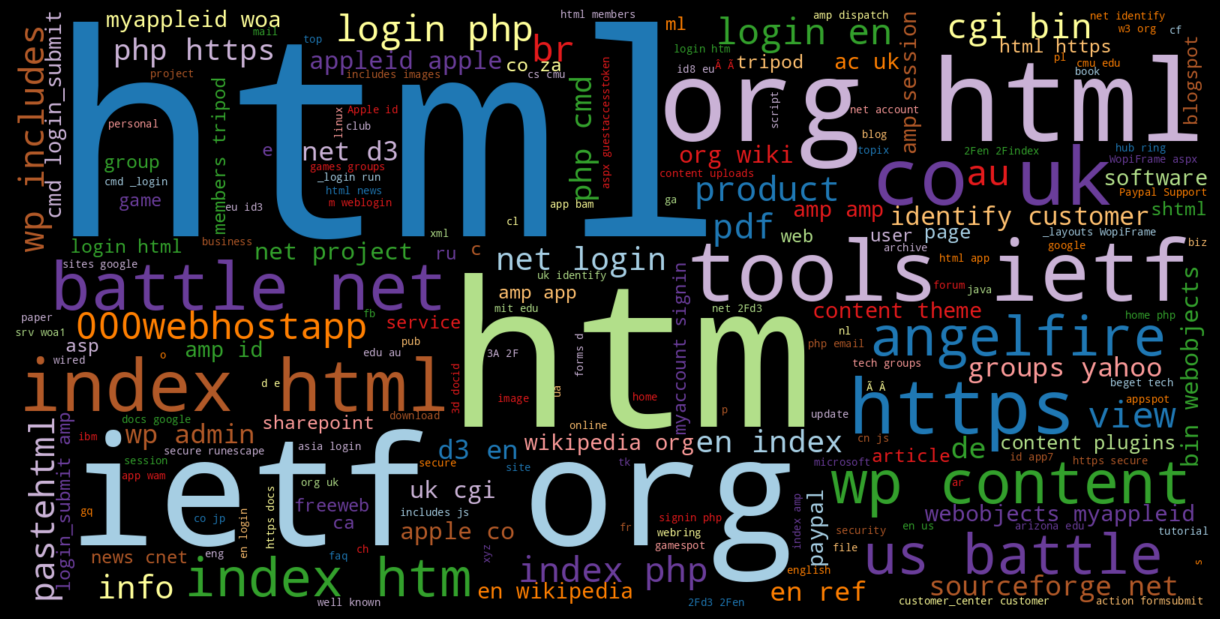

In [ ]:
phish_url = " ".join(i for i in df_phish.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(phish_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

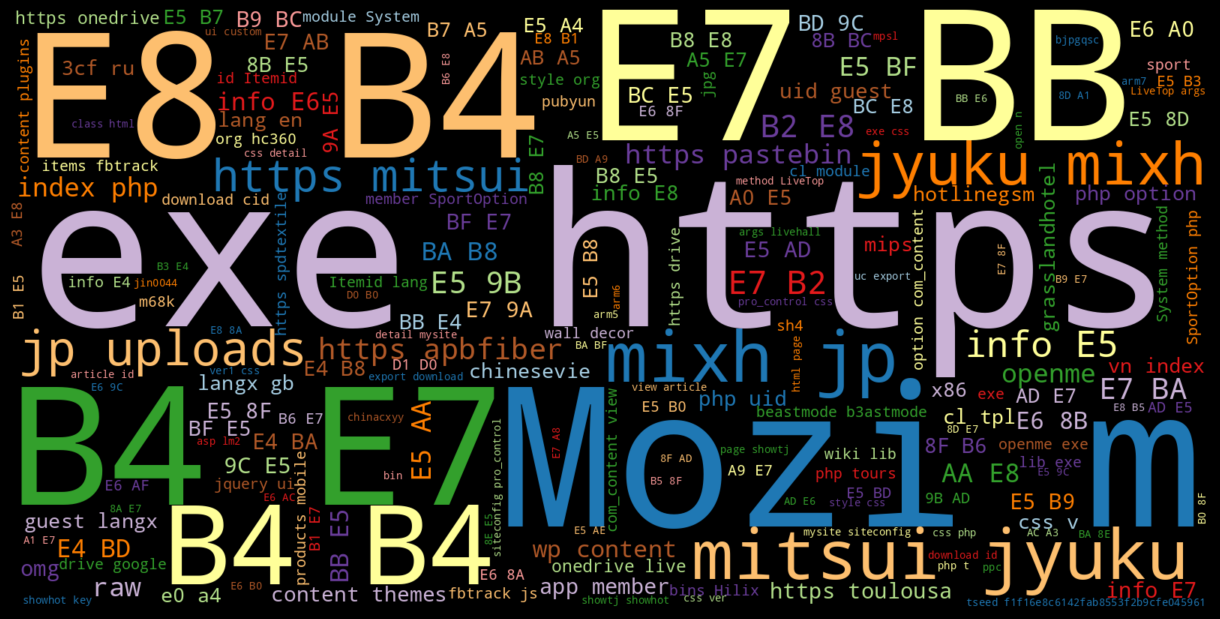

In [ ]:
malware_url = " ".join(i for i in df_malware.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(malware_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

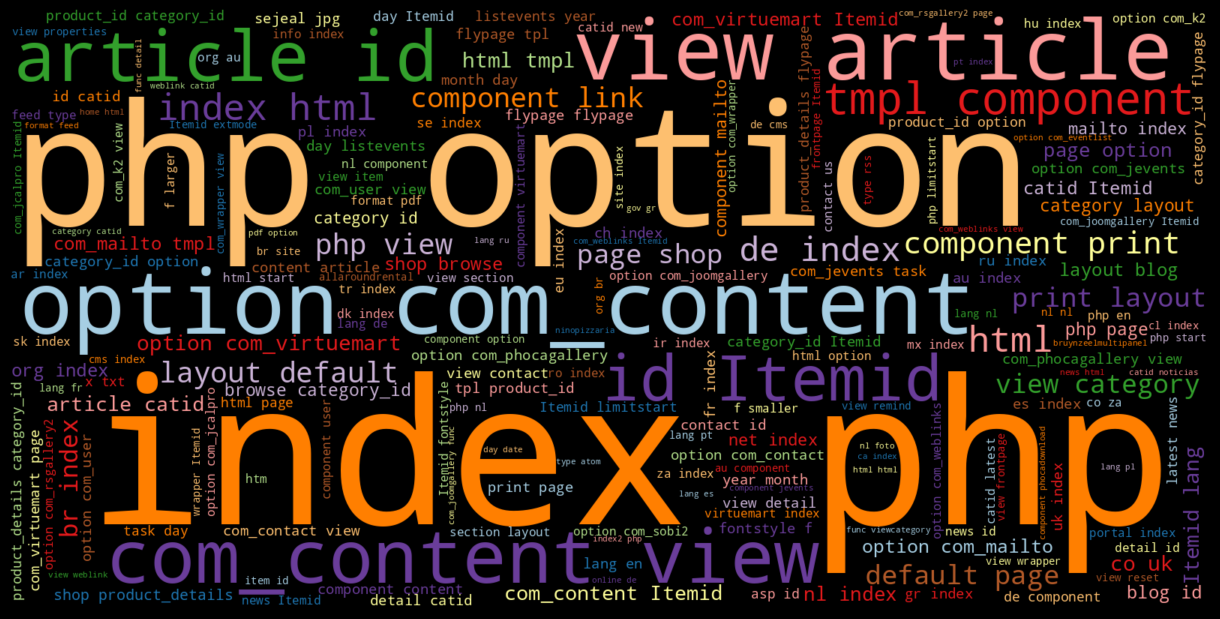

In [ ]:
deface_url = " ".join(i for i in df_deface.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(deface_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

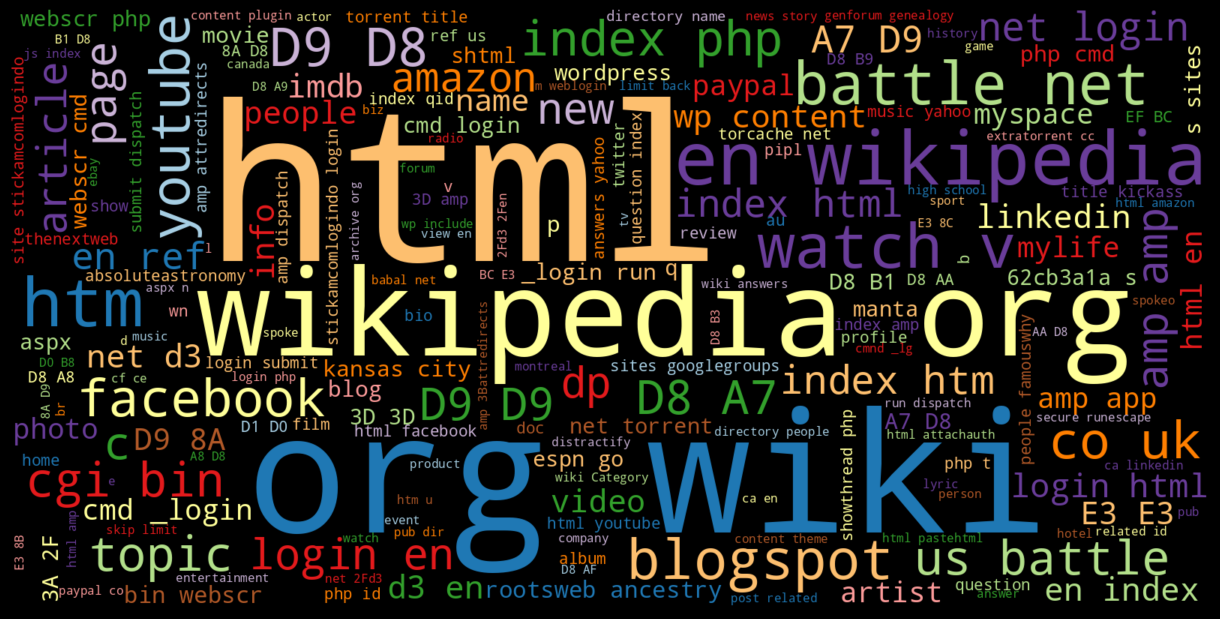

In [ ]:
benign_url = " ".join(i for i in df_benign.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(benign_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Feature Engineering

In [ ]:
!pip install tld

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import re
from urllib.parse import urlparse
from googlesearch import search
from tld import get_tld
import os.path

#Use of IP or not in domain: 1, 0
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

# 1 - URL pattern found, 0 - URL pattern not found
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

# G-index exists or not
def google_index(url):
    site = search(url, 5)
    return 1 if site else 0

# 
def count_dot(url):
    count_dot = url.count('.')
    return count_dot

def count_www(url):
    url.count('www')
    return url.count('www')

def count_atrate(url):
     
    return url.count('@')

def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
    
def count_https(url):
    return url.count('https')

def count_http(url):
    return url.count('http')

def count_per(url):
    return url.count('%')

def count_ques(url):
    return url.count('?')

def count_hyphen(url):
    return url.count('-')

def count_equal(url):
    return url.count('=')

def url_length(url):
    return len(str(url))

def hostname_length(url):
    return len(urlparse(url).netloc)

def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0

def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

#Length of Top Level Domain
def tld_length(tld):
    try:
        return len(tld)
    except:
        return 0


In [ ]:
# # Performing transformation on dataset
# df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))
# df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))
# df['google_index'] = df['url'].apply(lambda i: google_index(i))
# df['count.'] = df['url'].apply(lambda i: count_dot(i))
# df['count-www'] = df['url'].apply(lambda i: count_www(i))
# df['count@'] = df['url'].apply(lambda i: count_atrate(i))
# df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))
# df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embed(i))
# df['short_url'] = df['url'].apply(lambda i: shortening_service(i))
# df['count-https'] = df['url'].apply(lambda i : count_https(i))
# df['count-http'] = df['url'].apply(lambda i : count_http(i))
# df['count%'] = df['url'].apply(lambda i : count_per(i))
# df['count?'] = df['url'].apply(lambda i: count_ques(i))
# df['count-'] = df['url'].apply(lambda i: count_hyphen(i))
# df['count='] = df['url'].apply(lambda i: count_equal(i))
# df['url_length'] = df['url'].apply(lambda i: url_length(i))
# df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))
# df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))
# df['count-digits']= df['url'].apply(lambda i: digit_count(i))
# df['count-letters']= df['url'].apply(lambda i: letter_count(i))
# df['fd_length'] = df['url'].apply(lambda i: fd_length(i))
# df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))
# df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))

# # Discarding tld column
# df = df.drop("tld",1)
# df.columns

In [ ]:
# df['type'].value_counts()

In [ ]:
# Exporting transformed dataset
df.to_csv("exported_data.csv",index=False)

In [ ]:
# load pre-processed data
df = pd.read_csv("/content/drive/MyDrive/datasets/ml_data/exported_data.csv")

<Axes: xlabel='Label', ylabel='Count'>

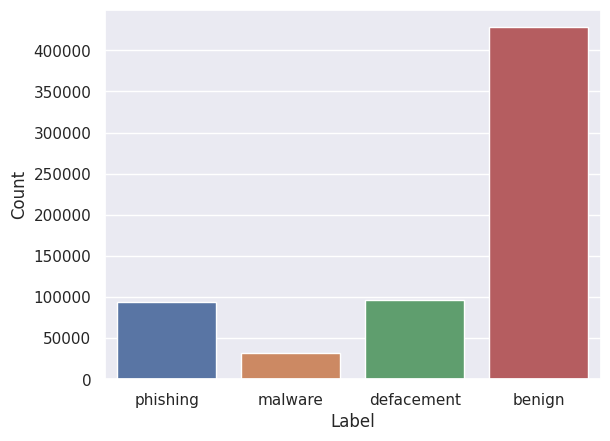

In [ ]:
# benign        428103
# defacement     96457
# phishing       94111
# malware        32520
df_phish = sum(df.type=='phishing')
df_malware = sum(df.type=='malware')
df_deface = sum(df.type=='defacement')
df_benign = sum(df.type=='benign')

count = [df_phish,df_malware,df_deface,df_benign]
labels = ['phishing','malware','defacement','benign'] 
data = pd.DataFrame({'Count': count, 'Label': labels})

sns.set(style="darkgrid")
sns.barplot(x="Label", y="Count", data=data)
# plt.bar(labels,count)

## 1. Distribution of use_of_ip

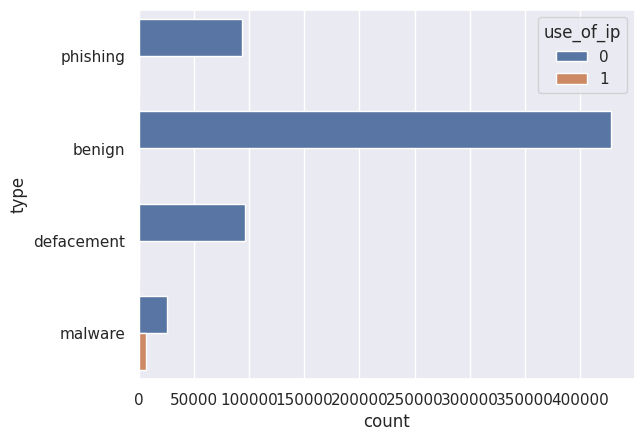

In [ ]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="use_of_ip")


## 2. Distribution of abnormal url

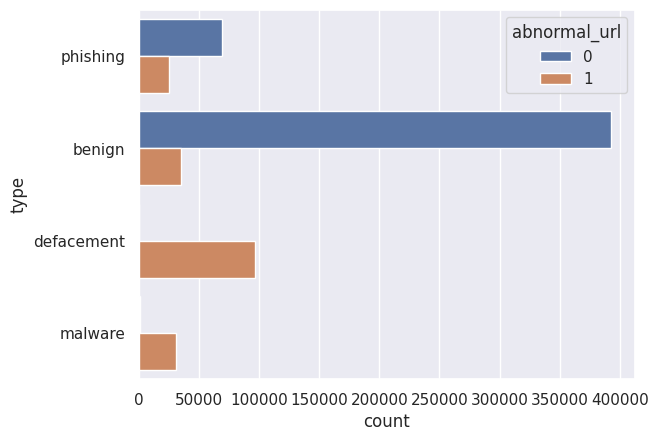

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="abnormal_url")


<ipython-input-44-86966ab47c1e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


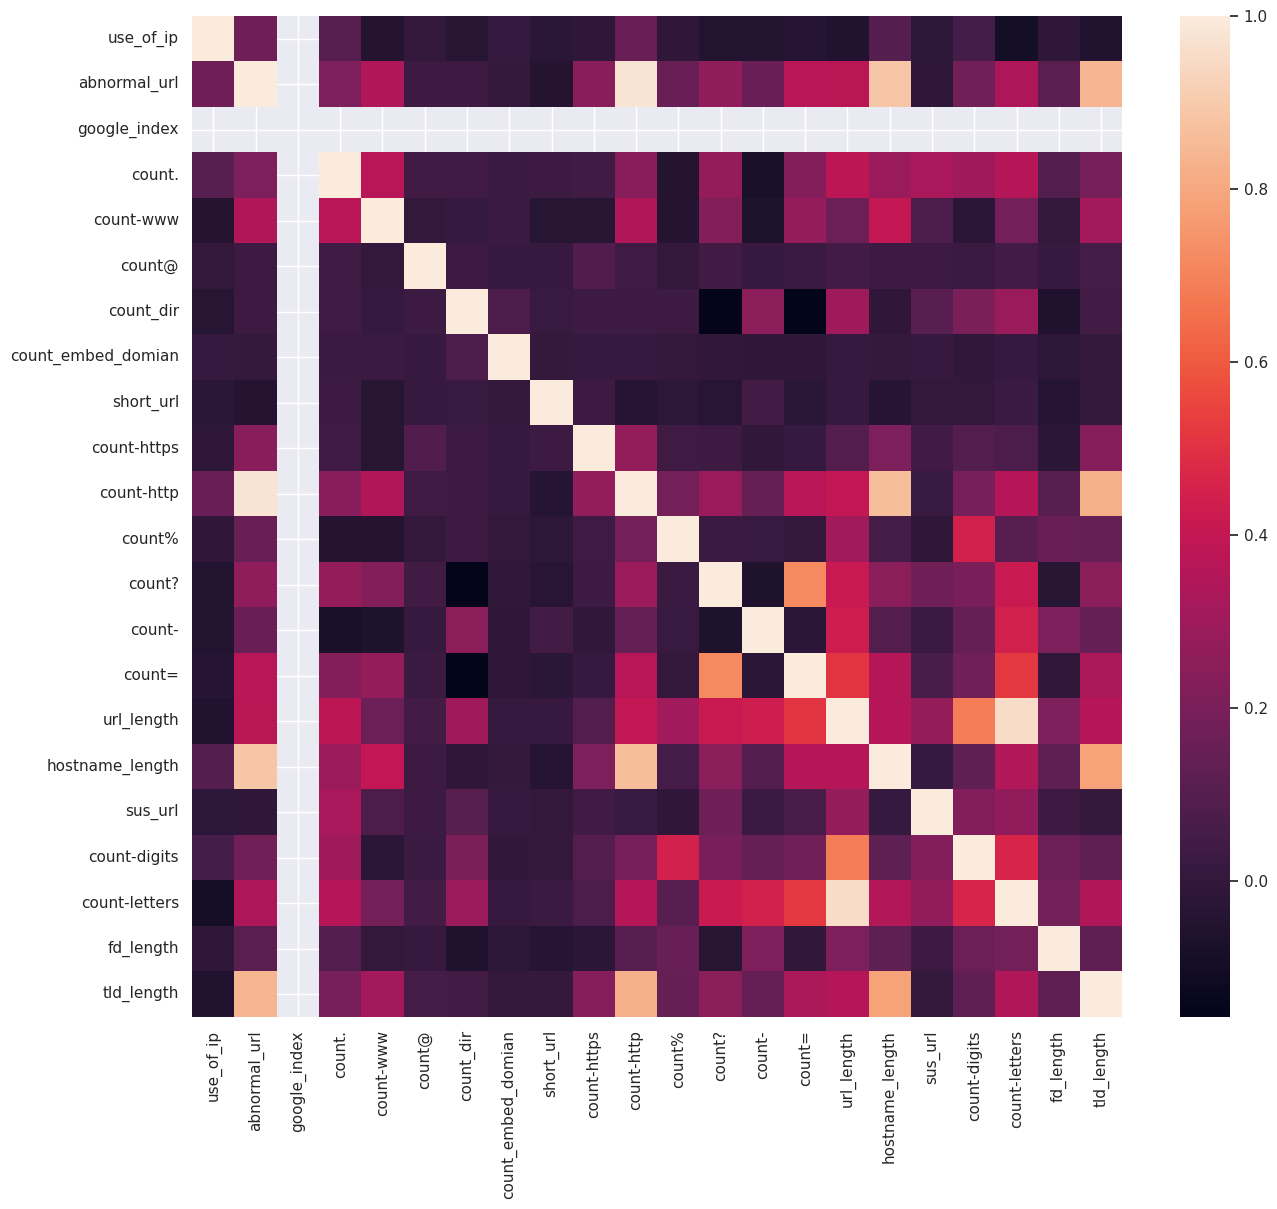

In [ ]:
plt.figure(figsize=(15,13))
sns.heatmap(df.corr())
plt.show()

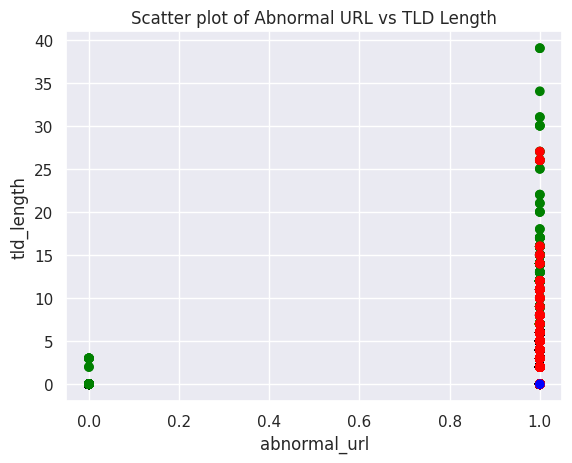

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a color map that maps each category to a color
color_map = {
    'benign': 'blue',
    'defacement': 'orange',
    'malware': 'red',
    'phishing': 'green'
}

# Apply the color map to the 'type' column to get a list of colors
colors = df['type'].map(color_map)

# Plot the scatter plot with the colors as the value of the 'c' parameter
plt.scatter(df['abnormal_url'], df['tld_length'], c=colors)
plt.xlabel('abnormal_url')
plt.ylabel('tld_length')
plt.title('Scatter plot of Abnormal URL vs TLD Length')
plt.show()


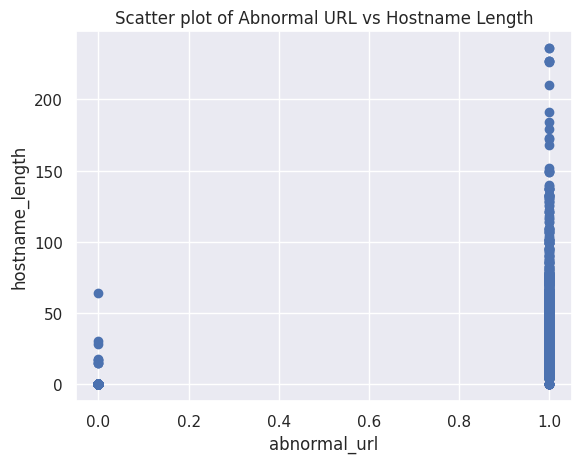

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(df['abnormal_url'],df['hostname_length'])
plt.xlabel('abnormal_url')
plt.ylabel('hostname_length')
plt.title('Scatter plot of Abnormal URL vs Hostname Length')
plt.show()


## 3. Distribution of Google Index

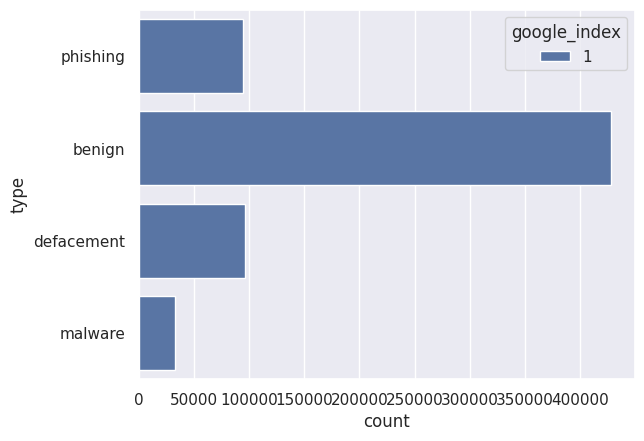

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="google_index")

## 4. Distribution of Shorl URL

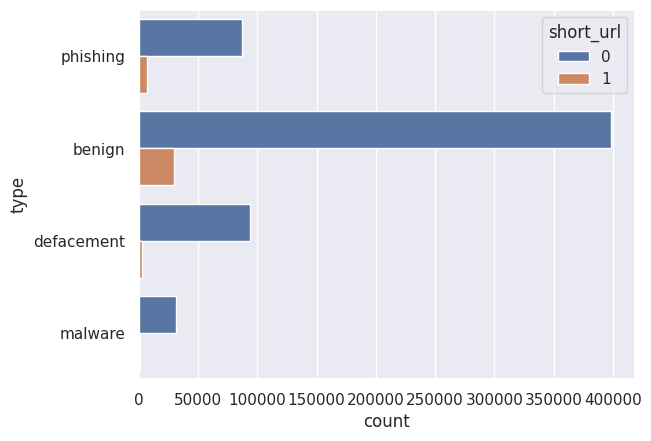

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="short_url")

## 5. Distribution of Suspicious URL

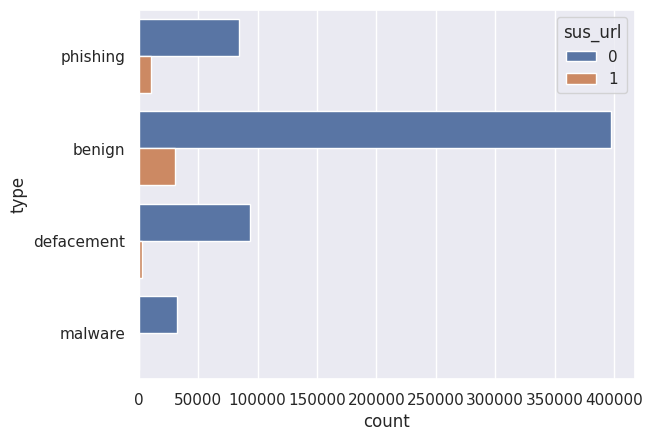

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="sus_url")

## 6. Distribution of count of [.] dot

Text(0.5, 1.0, 'Distribution of Dot Count')

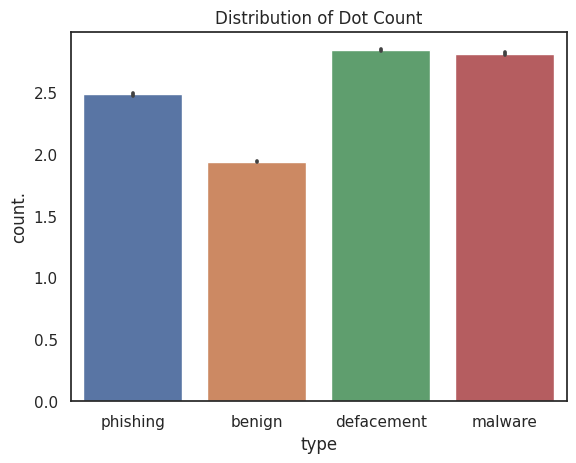

In [ ]:
sns.set(style="darkgrid")
sns.set_style('white')
ax = sns.barplot(x="type", y="count.", data=df)
plt.title("Distribution of Dot Count")

## 7. Distribution of count-www

Text(0.5, 1.0, 'Distribution of www count')

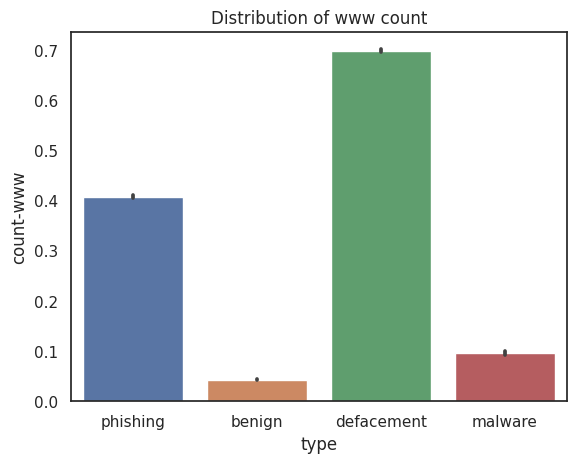

In [ ]:
sns.set(style="darkgrid")
sns.set_style("white")
ax = sns.barplot(x="type", y="count-www", data=df)
plt.title("Distribution of www count")

## 8. Distribution of count@

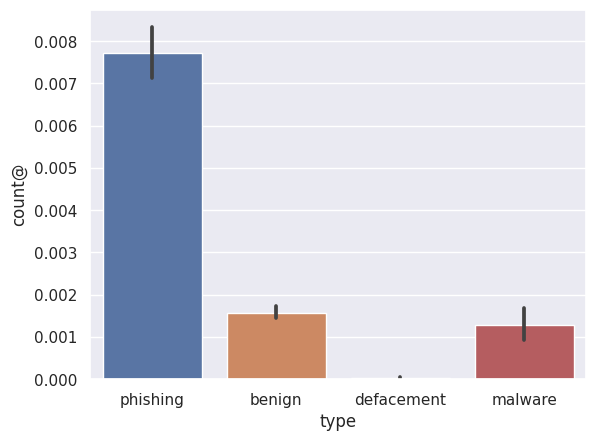

In [ ]:
sns.set(style="darkgrid")
ax = sns.barplot(x="type", y="count@", data=df)

## 9. Distribution of count_dir

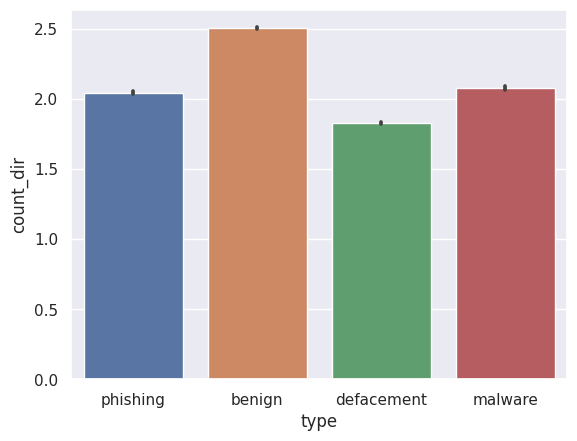

In [ ]:
sns.set(style="darkgrid")
ax = sns.barplot(x="type", y="count_dir", data=df)

## 10. Distribution of hostname length

Text(0.5, 1.0, 'Distribution of Hostname Length')

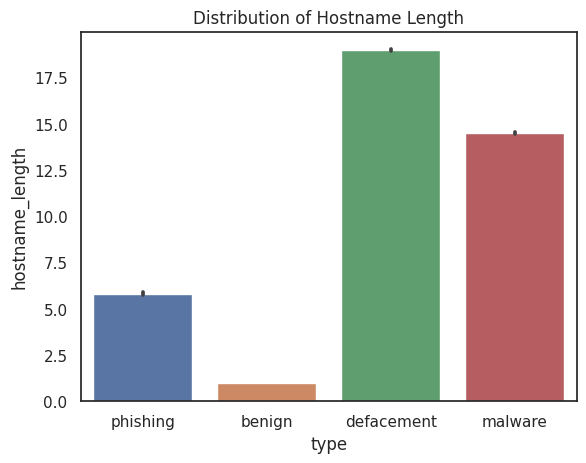

In [ ]:
sns.set(style="darkgrid")
sns.set_style("white")
ax = sns.barplot(x="type", y="hostname_length", data=df)
plt.title("Distribution of Hostname Length")

## 11. Distribution of first directory length

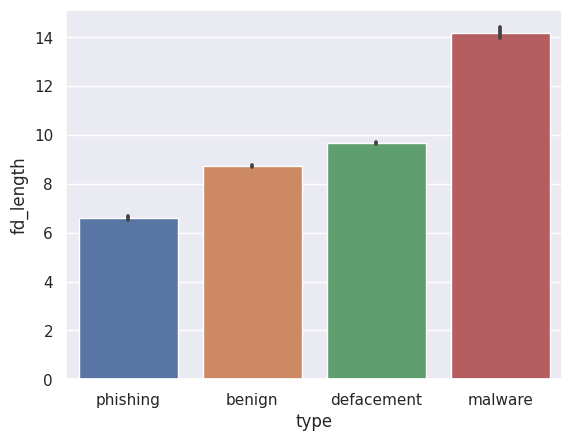

In [ ]:
sns.set(style="darkgrid")
ax = sns.barplot(x="type", y="fd_length", data=df)

## 12. Distribution of top-level domain length

Text(0.5, 1.0, 'Distribution of TLD Length')

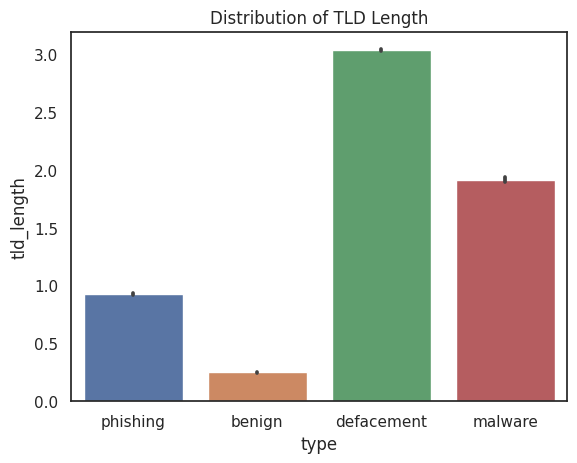

In [ ]:
sns.set(style="darkgrid")
sns.set_style("white")
ax = sns.barplot(x="type", y="tld_length", data=df)
plt.title("Distribution of TLD Length")

In [ ]:
sum((df['tld_length'] == 0) & (df['type'] == "benign"))

392725

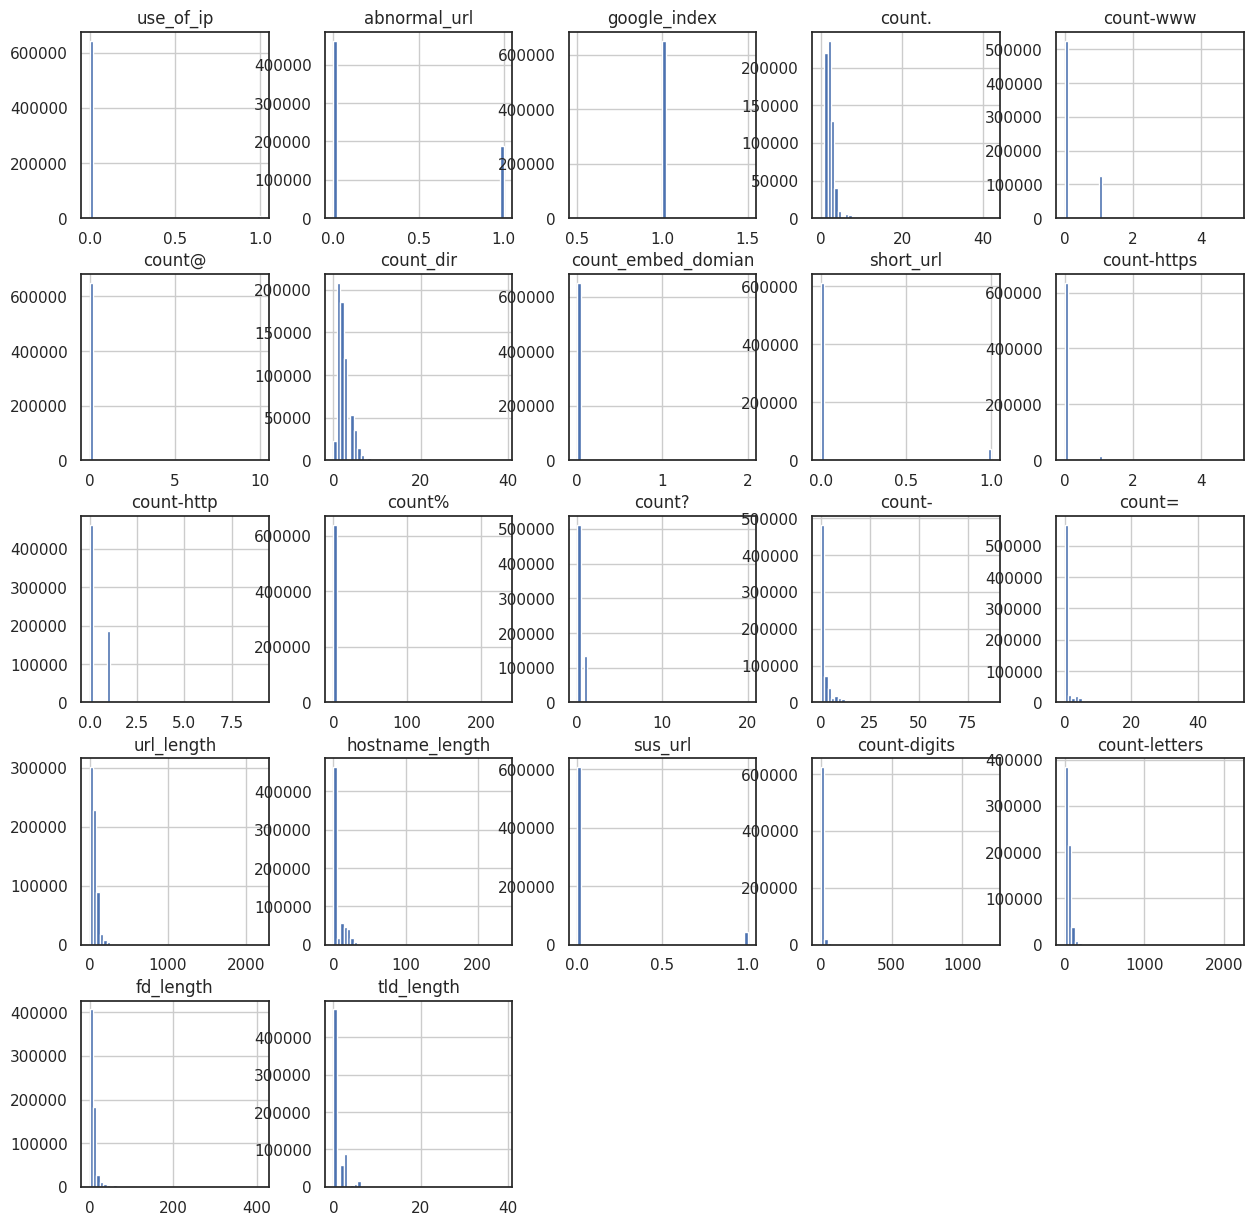

In [ ]:
df.hist(bins = 50,figsize = (15,15))
plt.show()

# **Target Encoding**

In [ ]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])
df["type_code"].value_counts()

0    428103
1     96457
3     94111
2     32520
Name: type_code, dtype: int64

# **Filtering essential features from dataset**

In [ ]:
#Predictor Variables
# filtering out google_index as it has only 1 value
X = df[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y = df['type_code']

# **Train Test Split**
- 80% training data \\
- 20% test data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

# **Model Recorder**
Function to record accuracy of each of the trained model over test data

In [ ]:
# Creating holders to store the model performance results
ML_Model = []
accu = []

#function to call for storing the results
def storeResults(model, a):
  ML_Model.append(model)
  accu.append(round(a, 3))

# **Model Selection**
Following models have been used:
1. Random Forest Classifier
2. Light GBM Classifier
3. XGBoost Classifier
4. Naive Bayes Classifier
5. Logistic Regression
6. Decision Tree Classifier
7. Autoencoder Neural Network
8. Multilayer Perceptron

## **1. Random Forest Classifier**

In [ ]:
rf = RandomForestClassifier(n_estimators=100,max_features='sqrt')
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test,y_pred_rf,target_names=['benign', 'defacement','phishing','malware']))

score = accuracy_score(y_test, y_pred_rf)
print("accuracy:   %0.3f" % score)
storeResults('Random Forest Classifier', score)

              precision    recall  f1-score   support

      benign       0.97      0.98      0.98     85621
  defacement       0.98      0.99      0.99     19292
    phishing       0.99      0.95      0.97      6504
     malware       0.91      0.86      0.88     18822

    accuracy                           0.97    130239
   macro avg       0.96      0.95      0.95    130239
weighted avg       0.97      0.97      0.97    130239

accuracy:   0.966


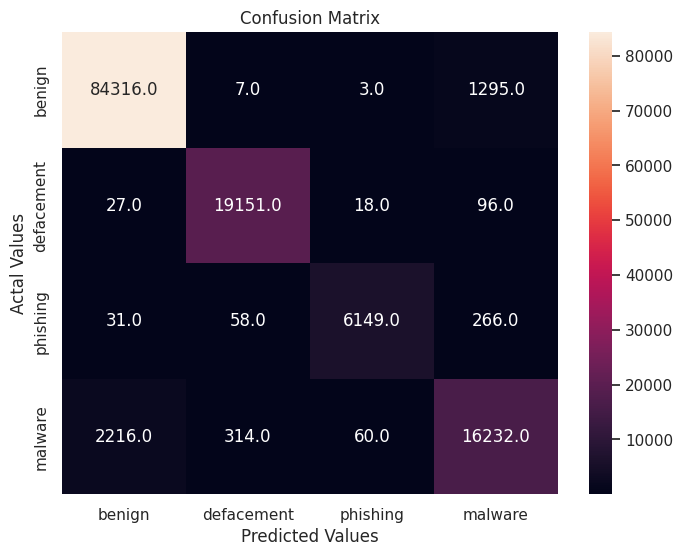

In [ ]:
cm = confusion_matrix(y_test, y_pred_rf)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

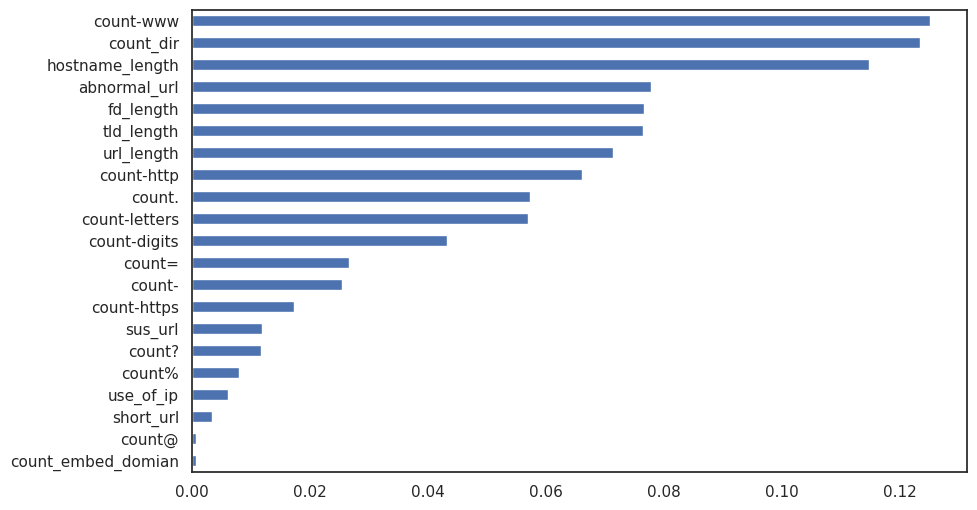

In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

## **2. Light GBM Classifier**

In [ ]:
lgb = LGBMClassifier(objective='multiclass',boosting_type= 'gbdt',n_jobs = 5, 
          silent = True, random_state=5)
LGB_C = lgb.fit(X_train, y_train)


y_pred_lgb = LGB_C.predict(X_test)
print(classification_report(y_test,y_pred_lgb,target_names=['benign', 'defacement','phishing','malware']))

score = accuracy_score(y_test, y_pred_lgb)
print("accuracy:   %0.3f" % score)
storeResults('Light GBM', score)

/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85621
  defacement       0.96      0.99      0.98     19292
    phishing       0.97      0.90      0.93      6504
     malware       0.90      0.83      0.86     18822

    accuracy                           0.96    130239
   macro avg       0.95      0.93      0.94    130239
weighted avg       0.96      0.96      0.96    130239

accuracy:   0.959


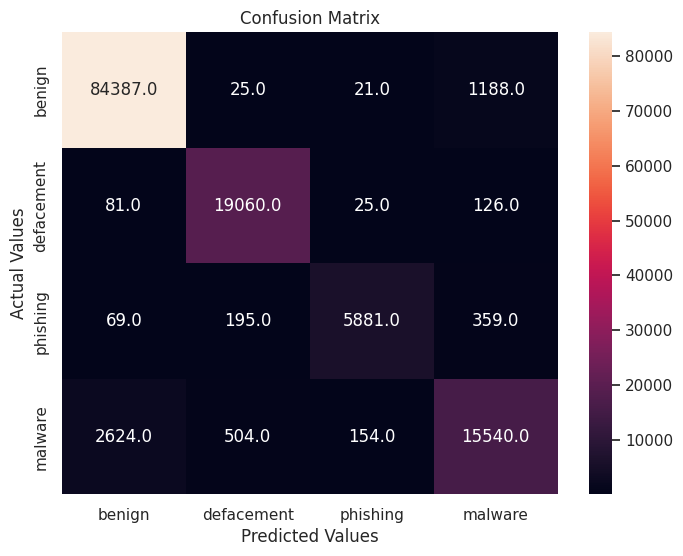

In [ ]:
cm = confusion_matrix(y_test, y_pred_lgb)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


<Axes: >

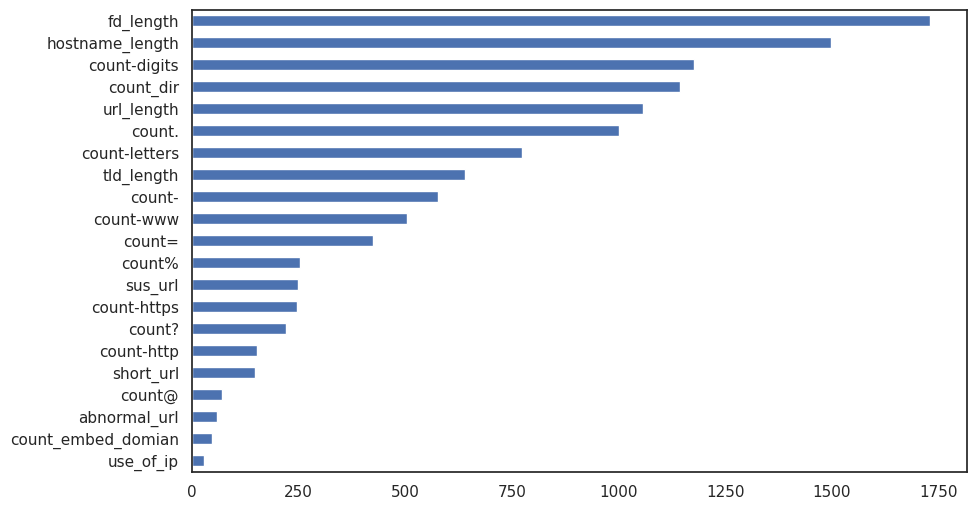

In [ ]:
feat_importances = pd.Series(lgb.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

## **3. XGboost Classifier**

In [ ]:
xgb_c = xgb.XGBClassifier(n_estimators= 100)
xgb_c.fit(X_train,y_train)
y_pred_x = xgb_c.predict(X_test)
print(classification_report(y_test,y_pred_x,target_names=['benign', 'defacement','phishing','malware']))


score = accuracy_score(y_test, y_pred_x)
print("accuracy:   %0.3f" % score)
storeResults('XGBoost Classifier', score)

              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85621
  defacement       0.97      0.99      0.98     19292
    phishing       0.97      0.92      0.94      6504
     malware       0.91      0.83      0.87     18822

    accuracy                           0.96    130239
   macro avg       0.96      0.93      0.94    130239
weighted avg       0.96      0.96      0.96    130239

accuracy:   0.962


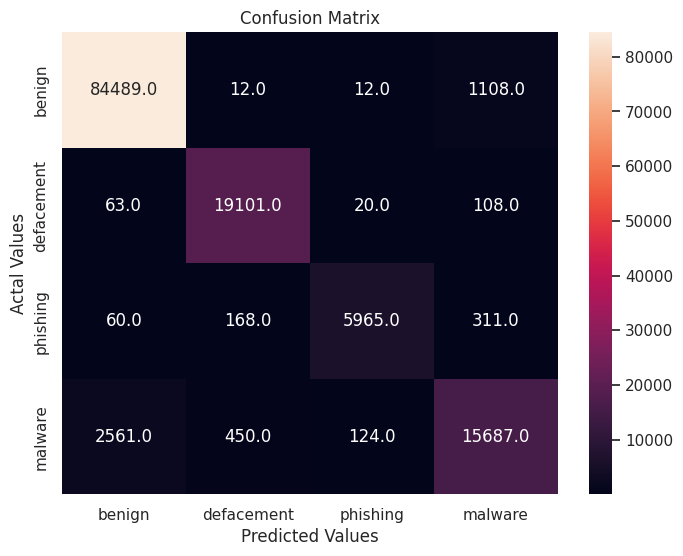

In [ ]:
cm = confusion_matrix(y_test, y_pred_x)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

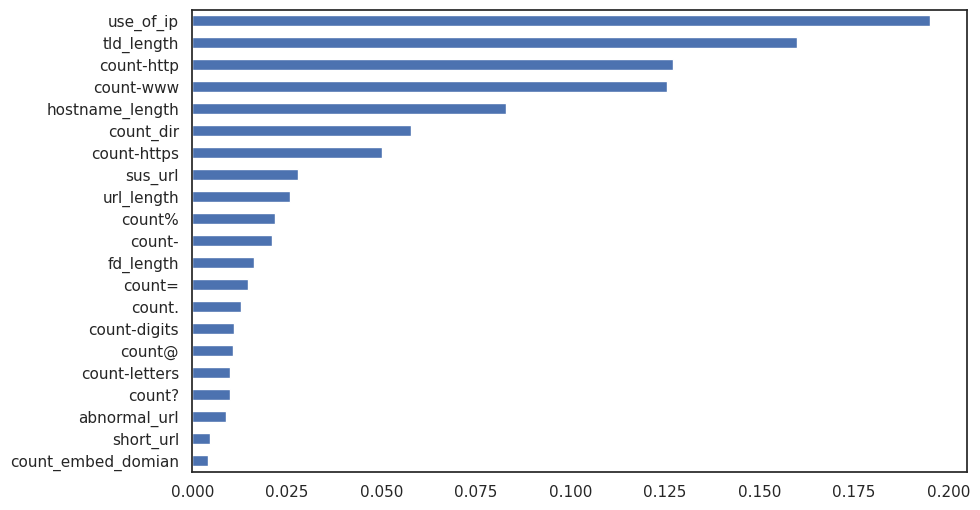

In [ ]:
feat_importances = pd.Series(xgb_c.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

##**4. Naive Bayes**

In [ ]:
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5],
    'priors': [None, [0.25, 0.25, 0.25, 0.25]],
}

nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_x = nb.predict(X_test)

print(classification_report(y_test,y_pred_x,target_names=['benign', 'defacement','phishing','malware']))

score = accuracy_score(y_test, y_pred_x)

print("accuracy:   %0.3f" % score)
storeResults('Naive Bayes Classifier', score)

              precision    recall  f1-score   support

      benign       0.91      0.89      0.90     85621
  defacement       0.64      1.00      0.78     19292
    phishing       0.59      0.55      0.57      6504
     malware       0.71      0.38      0.50     18822

    accuracy                           0.82    130239
   macro avg       0.71      0.70      0.69    130239
weighted avg       0.82      0.82      0.81    130239

accuracy:   0.815


In [ ]:


# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(nb, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and their score
print('Best hyperparameters:', grid_search.best_params_)
print('Best score: %0.2f' % grid_search.best_score_)

Best hyperparameters: {'priors': None, 'var_smoothing': 1e-05}
Best score: 0.83


##**5. Logistic Regression**

In [ ]:
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test,y_pred,target_names=['benign', 'defacement','phishing','malware']))

score = accuracy_score(y_test, y_pred)

print("accuracy:   %0.3f" % score)
storeResults('Logistic Regression', score)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

      benign       0.89      0.97      0.93     85621
  defacement       0.84      0.93      0.89     19292
    phishing       0.81      0.72      0.76      6504
     malware       0.76      0.40      0.52     18822

    accuracy                           0.87    130239
   macro avg       0.82      0.75      0.77    130239
weighted avg       0.86      0.87      0.86    130239

accuracy:   0.869


##**6. Decision Tree**

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test,y_pred,target_names=['benign', 'defacement','phishing','malware']))

score = metrics.accuracy_score(y_test, y_pred)

print("accuracy:   %0.3f" % score)
storeResults('Decision Tree', score)

              precision    recall  f1-score   support

      benign       0.97      0.98      0.97     85621
  defacement       0.98      0.99      0.98     19292
    phishing       0.95      0.94      0.95      6504
     malware       0.87      0.84      0.86     18822

    accuracy                           0.96    130239
   macro avg       0.94      0.94      0.94    130239
weighted avg       0.96      0.96      0.96    130239

accuracy:   0.958


##**7. Autoencoder Neural Network**

In [ ]:
#importing required packages

input_dim = X_train.shape[1]
encoding_dim = input_dim

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu",
                activity_regularizer=regularizers.l1(10e-4))(input_layer)
encoder = Dense(int(encoding_dim), activation="relu")(encoder)

encoder = Dense(int(encoding_dim-2), activation="relu")(encoder)
code = Dense(int(encoding_dim-4), activation='relu')(encoder)
decoder = Dense(int(encoding_dim-2), activation='relu')(code)

decoder = Dense(int(encoding_dim), activation='relu')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense (Dense)               (None, 21)                462       
                                                                 
 dense_1 (Dense)             (None, 21)                462       
                                                                 
 dense_2 (Dense)             (None, 19)                418       
                                                                 
 dense_5 (Dense)             (None, 21)                420       
                                                                 
 dense_6 (Dense)             (None, 21)                462       
                                                                 
Total params: 2,224
Trainable params: 2,224
Non-trainable par

In [ ]:
#compiling the model
autoencoder.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

#Training the model
history = autoencoder.fit(X_train, X_train, epochs=10, batch_size=64, shuffle=True, validation_split=0.2) 

Epoch 1/10
6512/6512 [==============================] - 19s 3ms/step - loss: -80.4257 - accuracy: 0.0422 - val_loss: -89.4318 - val_accuracy: 0.0644
Epoch 2/10
6512/6512 [==============================] - 20s 3ms/step - loss: -88.6415 - accuracy: 0.4749 - val_loss: -88.3397 - val_accuracy: 0.0000e+00
Epoch 3/10
6512/6512 [==============================] - 17s 3ms/step - loss: -88.2164 - accuracy: 0.0943 - val_loss: -90.0513 - val_accuracy: 0.9821
Epoch 4/10
6512/6512 [==============================] - 17s 3ms/step - loss: -90.0099 - accuracy: 0.4565 - val_loss: -90.9780 - val_accuracy: 0.3825
Epoch 5/10
6512/6512 [==============================] - 20s 3ms/step - loss: -90.8355 - accuracy: 0.2866 - val_loss: -91.1130 - val_accuracy: 1.7276e-04
Epoch 6/10
6512/6512 [==============================] - 17s 3ms/step - loss: -90.7523 - accuracy: 0.3847 - val_loss: -91.3698 - val_accuracy: 0.1911
Epoch 7/10
6512/6512 [==============================] - 17s 3ms/step - loss: -90.9802 - accuracy: 

In [ ]:
score = autoencoder.evaluate(X_test, X_test)[1]
print("accuracy:   %0.3f" % score)
storeResults('Autoencoder NN', score)

4070/4070 [==============================] - 6s 1ms/step - loss: -90.9833 - accuracy: 0.2857
accuracy:   0.286


## **8. Multilayer perceptrons**

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(alpha=0.001, hidden_layer_sizes=([25,25,25]))

mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

print(classification_report(y_test,y_pred,target_names=['benign', 'defacement','phishing','malware']))

score = metrics.accuracy_score(y_test, y_pred)

print("accuracy:   %0.3f" % score)
storeResults('Multlayer Perceptron', score)

              precision    recall  f1-score   support

      benign       0.96      0.99      0.97     85621
  defacement       0.95      0.97      0.96     19292
    phishing       0.94      0.87      0.91      6504
     malware       0.89      0.80      0.84     18822

    accuracy                           0.95    130239
   macro avg       0.94      0.91      0.92    130239
weighted avg       0.95      0.95      0.95    130239

accuracy:   0.951


# **Model Comparison**

In [ ]:
# creating dataframe
results = pd.DataFrame({ 'ML Model': ML_Model,    
    'Accuracy': accu})
results['Accuracy'] = [i*100 for i in results['Accuracy']]
results

,ML Model,Accuracy
0,Random Forest Classifier,96.6
1,Light GBM,95.9
2,XGBoost Classifier,96.2
3,Naive Bayes Classifier,81.5
4,Logistic Regression,86.9
5,Decision Tree,95.8
6,Autoencoder NN,28.6
7,Multlayer Perceptron,95.1


## **Plotting model accuracy graph**

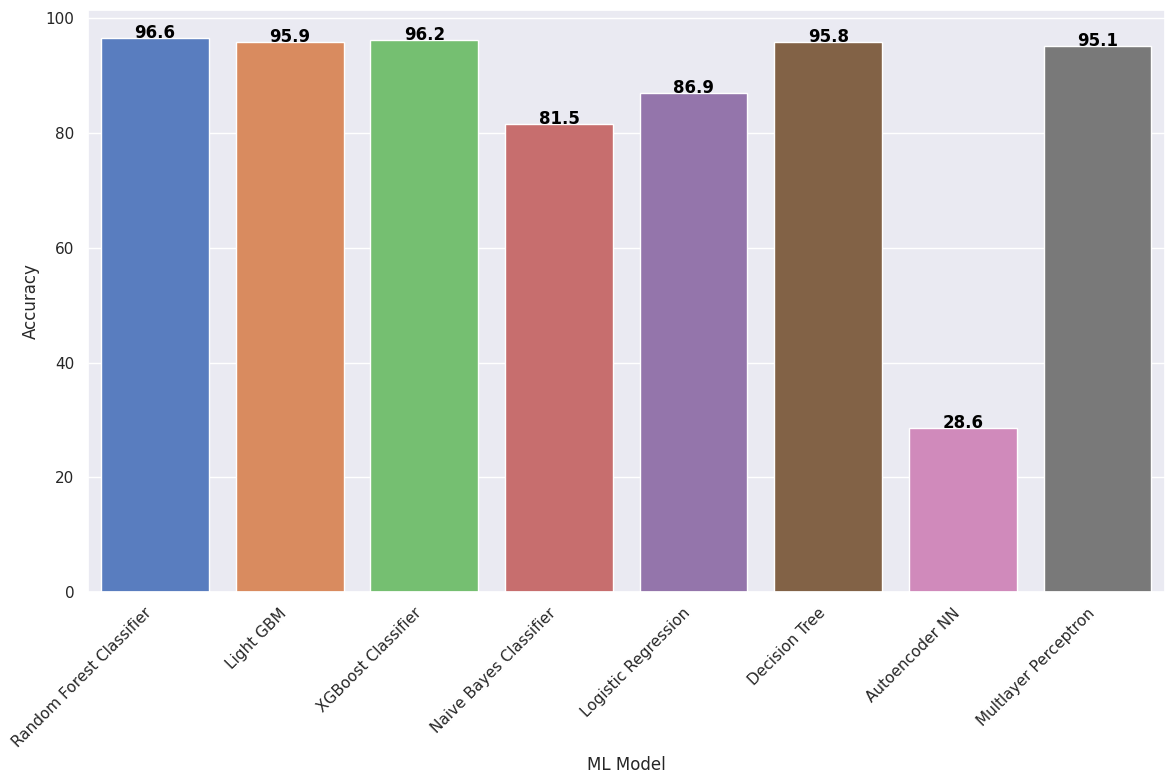

In [ ]:
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.barplot(x="ML Model", y="Accuracy", data=results, palette=sns.color_palette("muted", len(results)))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Add labels to the top of each bar
for i, v in enumerate(results['Accuracy']):
    ax.text(i, v, str(round(v, 3)), color='black', fontweight='bold', ha='center')

plt.tight_layout()
plt.show()

# **Prediction**
- This section contains function that takes a url as input and runs the sample on the trained model to produce prediction

In [ ]:
# Function that transform the url into a feature set
def main(url):
    
    status = []
    
    status.append(having_ip_address(url))
    status.append(abnormal_url(url))
    status.append(count_dot(url))
    status.append(count_www(url))
    status.append(count_atrate(url))
    status.append(no_of_dir(url))
    status.append(no_of_embed(url))
    
    status.append(shortening_service(url))
    status.append(count_https(url))
    status.append(count_http(url))
    
    status.append(count_per(url))
    status.append(count_ques(url))
    status.append(count_hyphen(url))
    status.append(count_equal(url))
    
    status.append(url_length(url))
    status.append(hostname_length(url))
    status.append(suspicious_words(url))
    status.append(digit_count(url))
    status.append(letter_count(url))
    status.append(fd_length(url))
    tld = get_tld(url,fail_silently=True)
      
    status.append(tld_length(tld))
    return status

In [ ]:
def get_prediction_from_url(test_url):
    features_test = main(test_url)
    # Due to updates to scikit-learn, we now need a 2D array as a parameter to the predict function.
    features_test = np.array(features_test).reshape((1, -1))

    pred = rf.predict(features_test)
    if int(pred[0]) == 0:
        res="SAFE"
        return res
    elif int(pred[0]) == 1.0:
        res="DEFACEMENT"
        return res
    elif int(pred[0]) == 2.0:
        res="PHISHING"
        return res
    elif int(pred[0]) == 3.0:
        res="MALWARE"
        return res

In [ ]:
# Running a sample URL through the model
urls = ['www.wikipedia.com','signin.eby.de.zukruygxctzmmqi.civpro.co.za']
for url in urls:
     print(get_prediction_from_url(url))

SAFE
MALWARE
